# Deep-NLP

NLP allows computers to interact with text data in a structured and sensible way. We will be breaking up series of texts into individual words (or groups of words), and isolating the words with semantic value. 


In [122]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
import string

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Business Understanding

## Data Understanding

In [90]:
df_response = pd.read_csv('../data/Sheet_1.csv', encoding='utf-8')

In [91]:
df_response.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


df1.info()

Drop all "Unnamed" columns, they don't have any useful information.

In [92]:
df_resume = pd.read_csv('../data/Sheet_2.csv', encoding="latin-1")

In [93]:
df_resume

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


## Data Preparation

In [94]:
df_response.drop(['response_id','Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], axis=1, inplace=True)

In [95]:
df_response

,class,response_text
0,not_flagged,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...
...,...,...
75,not_flagged,"Now that I've been through it, although i'm no..."
76,flagged,when my best friends mom past away from od'ing...
77,not_flagged,As a camp counselor I provide stability in kid...
78,flagged,My now girlfriend used to have serious addicti...


In [96]:
print("We have {} of documents in the corpus".format(df_response.shape[0]))

We have 80 of documents in the corpus


In [97]:
df_response['class'].value_counts(normalize=True)

not_flagged    0.6875
flagged        0.3125
Name: class, dtype: float64

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


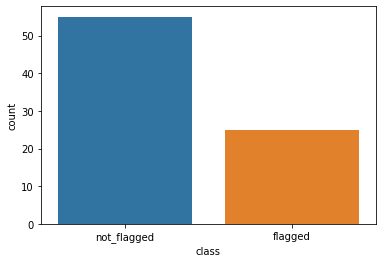

In [98]:
sns.countplot(df_response['class']);

 Get a wordcloud of the raw text before cleaning

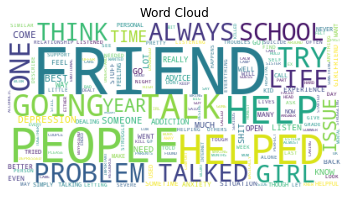

In [99]:
def wordcloud(df):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in df.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Word Cloud")

wordcloud(df_response['response_text'])

## Data Cleaning

In [100]:
def clean_text(res_text):
    
    # covnert all to lowr case
    res_text = res_text.lower()
    
    # Remove texts in square brackets
    res_text = re.sub('\[.*?\]', '', res_text)
    
    # http link address can be filtered
    res_text = re.sub('https?://\S+|www\.\S+', '', res_text)
    
    # Remove punctuations
    res_text = re.sub('<.*?>+', '', res_text)  
    res_text = re.sub('[%s]' % re.escape(string.punctuation), '', res_text)
    res_text = re.sub('\n', '', res_text)    
    
    # Remove words with numbers
    res_text = re.sub('\w*\d\w*', '', res_text)
     
    return res_text

# Applying the cleaning function to both test and training datasets
df_response['response_text'] = df_response['response_text'].apply(lambda x: clean_text(x))

In [101]:
df_response

,class,response_text
0,not_flagged,i try and avoid this sort of conflict
1,flagged,had a friend open up to me about his mental ad...
2,flagged,i saved a girl from suicide once she was going...
3,not_flagged,i cant think of one reallyi think i may have i...
4,not_flagged,only really one friend who doesnt fit into the...
...,...,...
75,not_flagged,now that ive been through it although im not e...
76,flagged,when my best friends mom past away from oding ...
77,not_flagged,as a camp counselor i provide stability in kid...
78,flagged,my now girlfriend used to have serious addicti...


Print a wordcloud for each class

In [102]:
flagged_values = df_response[df_response['class']=='flagged']['response_text']
not_flagged_values=df_response[df_response['class']=='not_flagged']['response_text']

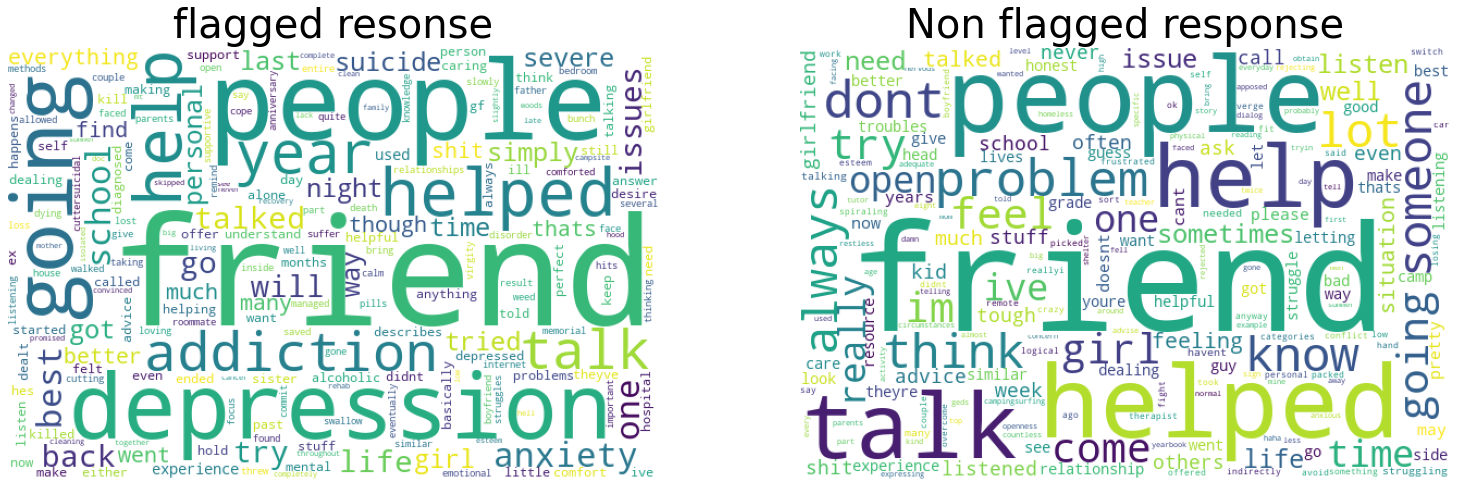

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(flagged_values))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('flagged resonse',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_flagged_values))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non flagged response',fontsize=40);

## Data Preprocessing

In [104]:
# Encoding
res_enc= LabelEncoder()

res_enc.fit(df_response['class'])
#le.classes_
df_response['class']=res_enc.transform(df_response['class']) 
df_response.head()

,class,response_text
0,1,i try and avoid this sort of conflict
1,0,had a friend open up to me about his mental ad...
2,0,i saved a girl from suicide once she was going...
3,1,i cant think of one reallyi think i may have i...
4,1,only really one friend who doesnt fit into the...


In [105]:
X = df_response.response_text
y = df_response['class']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
df_response

,class,response_text
0,1,i try and avoid this sort of conflict
1,0,had a friend open up to me about his mental ad...
2,0,i saved a girl from suicide once she was going...
3,1,i cant think of one reallyi think i may have i...
4,1,only really one friend who doesnt fit into the...
...,...,...
75,1,now that ive been through it although im not e...
76,0,when my best friends mom past away from oding ...
77,1,as a camp counselor i provide stability in kid...
78,0,my now girlfriend used to have serious addicti...


In [108]:
nb = MultinomialNB()
tfid_vect = TfidfVectorizer()
count_vect = CountVectorizer()

In [109]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64,), (16,), (64,), (16,))

In [114]:
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

In [115]:
y_train.head

<bound method NDFrame.head of 73    1
61    0
55    1
40    0
9     0
     ..
20    1
60    1
71    1
14    1
51    0
Name: class, Length: 64, dtype: int64>

## MultinomialNB
Naïve Bayes, which is computationally very efficient and easy to implement, is a learning algorithm frequently used in text classification problems. The multivariate event model is referred to as Multinomial Naive Bayes

In [116]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [117]:
y_predict = nb.predict(X_test)

In [118]:
y_predict

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0])

In [119]:
metrics.accuracy_score(y_test, y_predict)

0.5625

## GuassianNB

In [126]:
nb = GaussianNB()
count_vect.fit_transform

## RandomForest

In [120]:
rf = RandomForestClassifier(max_depth=10, max_features=10)
rf.fit(X_train,y_train)
rf_predict = rf.predict(X_test)
metrics.accuracy_score(y_test, rf_predict)

0.875